In [36]:
import pandas as pd 
import numpy as np
import re
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from keras import models
from keras.models import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.pyplot import figure
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import f1_score


In [2]:
def process(file_path:str):
    with open(file_path) as f:
        text = f.readlines()

    data = []
    for sent in text:
        sent = sent.replace('\n','')
        data.append(sent)

    for i in range(len(data)):
        data[i] = data[i].split(' ')

    return data


In [3]:
data_train_path = '/content/drive/MyDrive/PhoATIS/word-level/train/seq.in'
data_dev_path = '/content/drive/MyDrive/PhoATIS/word-level/dev/seq.in'
data_test_path = '/content/drive/MyDrive/PhoATIS/word-level/test/seq.in'

In [6]:
data_train = process(data_train_path)
data_dev = process(data_dev_path)
data_test = process(data_test_path)

In [7]:
def max_length(words):
  return(len(max(words, key = len)))

In [8]:
print('max length data train: ',max_length(data_train))
print('max length data dev: ',max_length(data_dev))
print('max length data test: ',max_length(data_test))

max length data train:  50
max length data dev:  36
max length data test:  37


In [9]:
def load_label(file_path:str):
    with open(file_path) as f:
        text = f.readlines()

    labels = []
    for label in text:
        label = label.replace('\n','')
        labels.append(label)

    return labels

In [10]:
label_train_path = '/content/drive/MyDrive/PhoATIS/word-level/train/label'
label_test_path = '/content/drive/MyDrive/PhoATIS/word-level/test/label'
label_dev_path = '/content/drive/MyDrive/PhoATIS/word-level/dev/label'

In [11]:
labels_train = load_label(label_train_path)
labels_test = load_label(label_test_path)
labels_dev = load_label(label_dev_path)

In [12]:
label_list = sorted(list(set(labels_train + labels_test + labels_dev)))

In [13]:
label_dict = {v:k for k,v in enumerate(label_list)}

In [14]:
label_dict

{'abbreviation': 0,
 'aircraft': 1,
 'aircraft#flight': 2,
 'aircraft#flight#flight_no': 3,
 'airfare': 4,
 'airfare#flight': 5,
 'airfare#flight_time': 6,
 'airline': 7,
 'airline#flight': 8,
 'airline#flight_no': 9,
 'airport': 10,
 'capacity': 11,
 'city': 12,
 'city#flight_time': 13,
 'day_name': 14,
 'distance': 15,
 'flight': 16,
 'flight#flight_no': 17,
 'flight#flight_time': 18,
 'flight_no': 19,
 'flight_no#flight_time': 20,
 'flight_time': 21,
 'ground_fare': 22,
 'ground_fare#ground_service': 23,
 'ground_service': 24,
 'meal': 25,
 'quantity': 26,
 'restriction': 27}

In [15]:
y_train = [label_dict[v] for v in labels_train]
y_test = [label_dict[v] for v in labels_test]
y_dev = [label_dict[v] for v in labels_dev]

y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)

In [16]:
vocab = []
for i in range(len(data_train)):
    for word in data_train[i]:
        vocab.append(word)

for x in range(len(data_test)):
    for word in data_test[x]:
        vocab.append(word)

for t in range(len(data_dev)):
    for word in data_dev[t]:
        vocab.append(word)

print('Vocab có {0} từ'.format(len(vocab)))
print('Vocab có {0} từ độc lập'.format(len(list(set(vocab)))))

Vocab có 77109 từ
Vocab có 1194 từ độc lập


In [17]:
vocab_size = len(list(set(vocab)))
vocab_size

1194

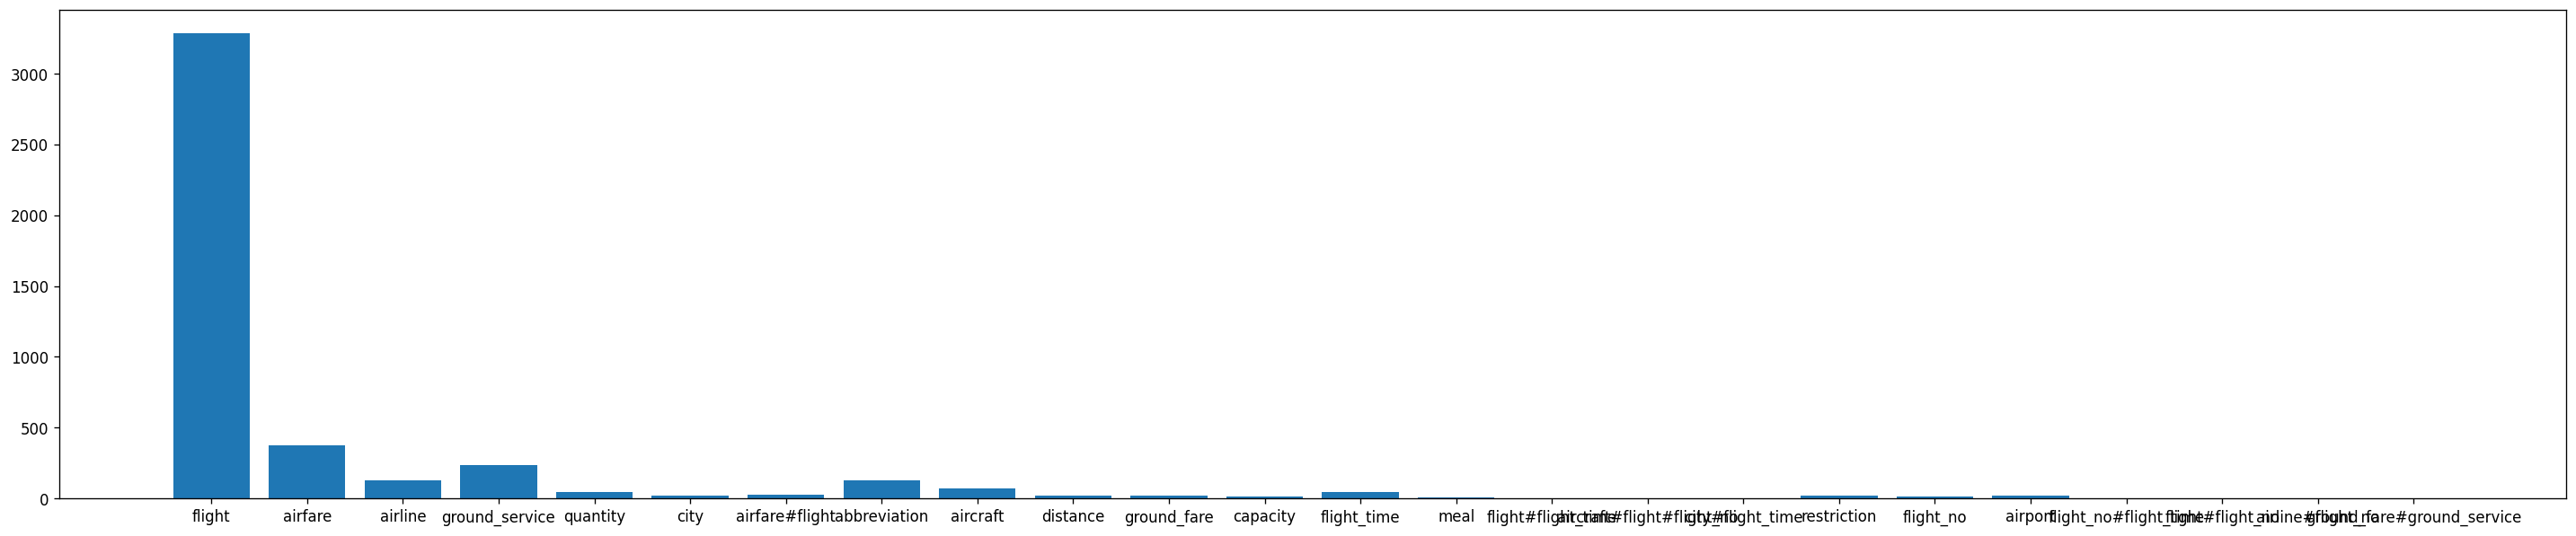

In [18]:
figure(figsize=(30, 6), dpi=120)
c = Counter(labels_train)

plt.bar(c.keys(), c.values())
plt.show()

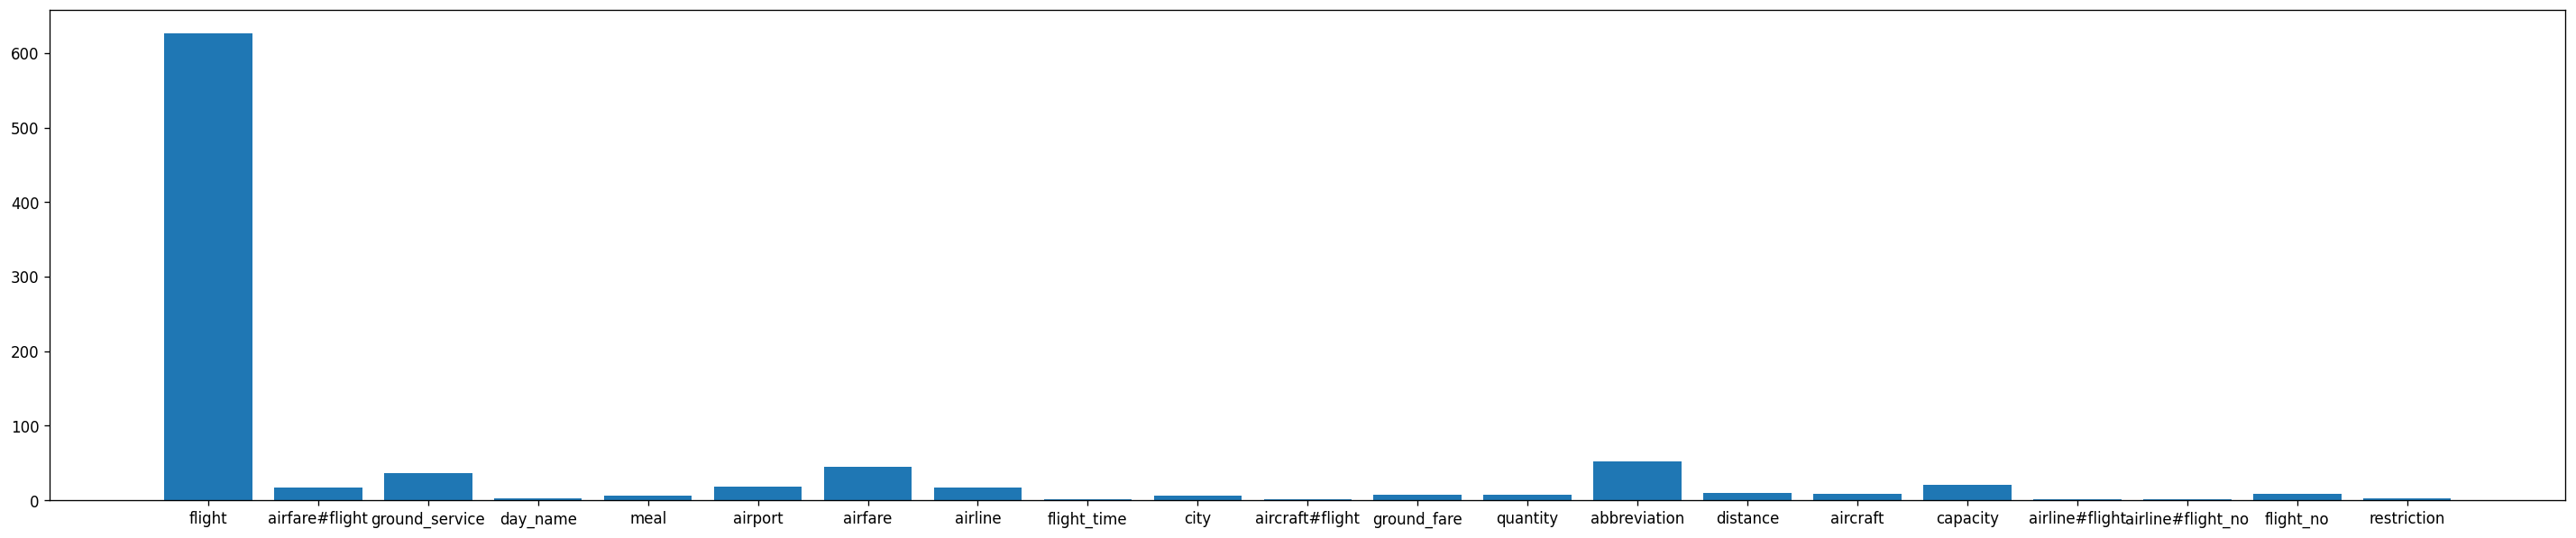

In [19]:
figure(figsize=(30, 6), dpi=120)
c = Counter(labels_test)

plt.bar(c.keys(), c.values())
plt.show()

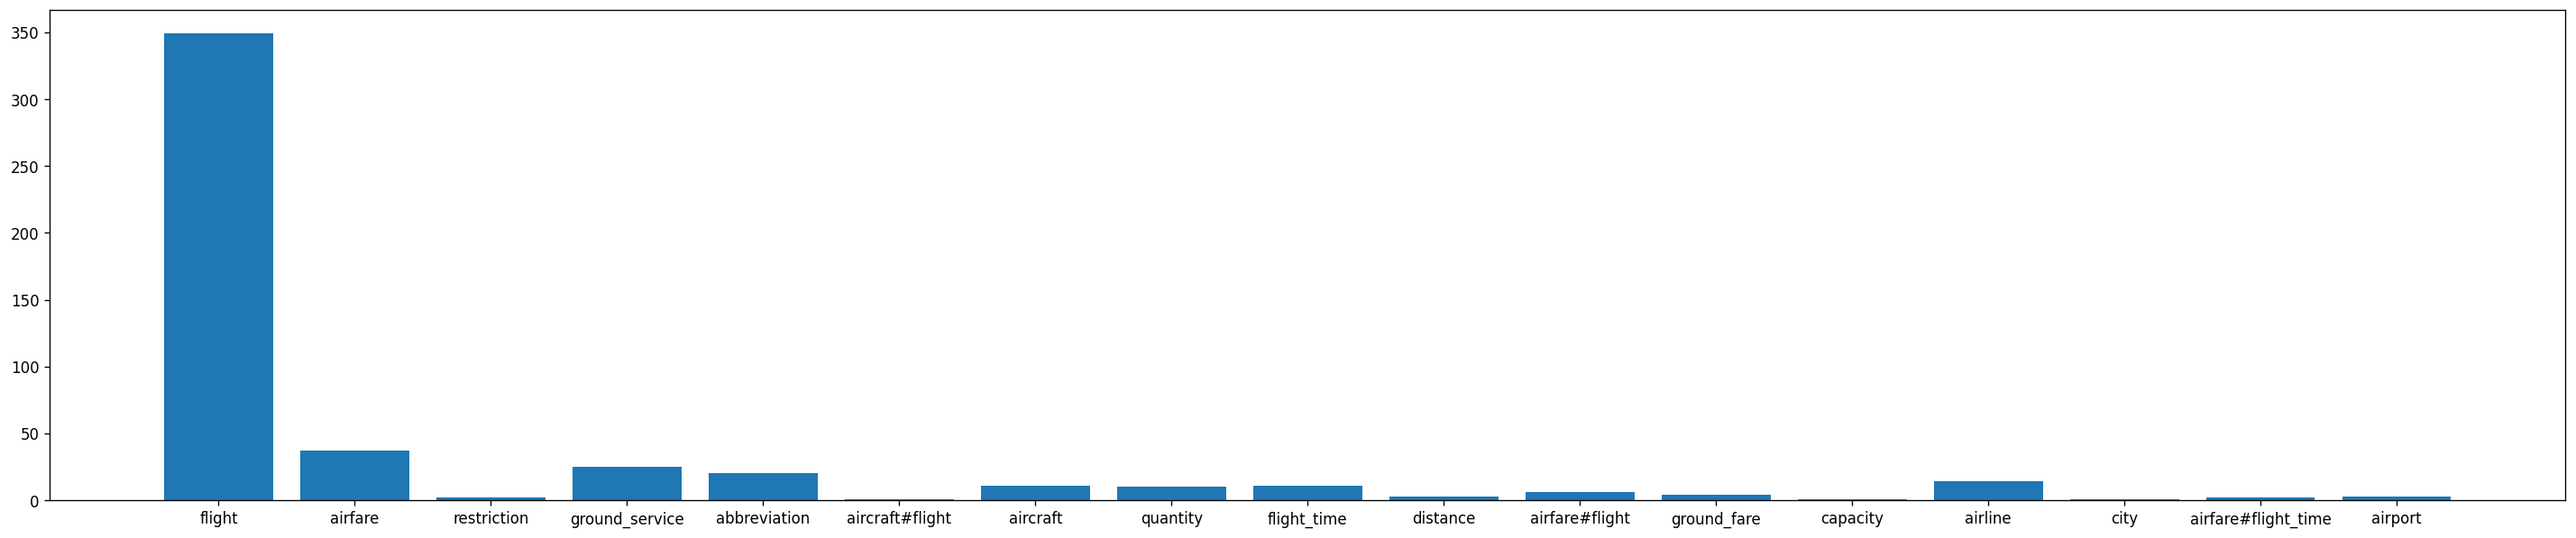

In [20]:
figure(figsize=(30, 6), dpi=120)
c = Counter(labels_dev)

plt.bar(c.keys(), c.values())
plt.show()

In [21]:
print('Số lượng các intent trong tập train:')
for i in label_list:
    print('{0} : '.format(i),labels_train.count(i))

Số lượng các intent trong tập train:
abbreviation :  130
aircraft :  72
aircraft#flight :  0
aircraft#flight#flight_no :  2
airfare :  375
airfare#flight :  28
airfare#flight_time :  0
airline :  126
airline#flight :  0
airline#flight_no :  2
airport :  17
capacity :  15
city :  19
city#flight_time :  1
day_name :  0
distance :  18
flight :  3284
flight#flight_no :  1
flight#flight_time :  1
flight_no :  11
flight_no#flight_time :  1
flight_time :  48
ground_fare :  18
ground_fare#ground_service :  1
ground_service :  237
meal :  7
quantity :  42
restriction :  22


In [22]:
print('Số lượng các intent trong tập test:')
for i in label_list:
    print('{0} : '.format(i),labels_test.count(i))

Số lượng các intent trong tập test:
abbreviation :  52
aircraft :  9
aircraft#flight :  1
aircraft#flight#flight_no :  0
airfare :  45
airfare#flight :  17
airfare#flight_time :  0
airline :  17
airline#flight :  1
airline#flight_no :  1
airport :  18
capacity :  21
city :  6
city#flight_time :  0
day_name :  2
distance :  10
flight :  626
flight#flight_no :  0
flight#flight_time :  0
flight_no :  8
flight_no#flight_time :  0
flight_time :  1
ground_fare :  7
ground_fare#ground_service :  0
ground_service :  36
meal :  6
quantity :  7
restriction :  2


In [23]:
print('Số lượng các intent trong tập dev:')
for i in label_list:
    print('{0} : '.format(i),labels_dev.count(i))

Số lượng các intent trong tập dev:
abbreviation :  20
aircraft :  11
aircraft#flight :  1
aircraft#flight#flight_no :  0
airfare :  37
airfare#flight :  6
airfare#flight_time :  2
airline :  14
airline#flight :  0
airline#flight_no :  0
airport :  3
capacity :  1
city :  1
city#flight_time :  0
day_name :  0
distance :  3
flight :  349
flight#flight_no :  0
flight#flight_time :  0
flight_no :  0
flight_no#flight_time :  0
flight_time :  11
ground_fare :  4
ground_fare#ground_service :  0
ground_service :  25
meal :  0
quantity :  10
restriction :  2


In [24]:
max_length = 50

In [25]:
max_length

50

In [26]:
tokenizer= Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(data_train)
tokenizer.fit_on_texts(data_dev)
tokenizer.fit_on_texts(data_test)

tokenized_train= tokenizer.texts_to_sequences(data_train)
tokenized_dev= tokenizer.texts_to_sequences(data_dev)
tokenized_test= tokenizer.texts_to_sequences(data_test)

In [27]:
train_padded= pad_sequences(tokenized_train, maxlen= max_length, padding= "pre")
dev_padded = pad_sequences(tokenized_dev, maxlen= max_length, padding= "pre")
test_padded = pad_sequences(tokenized_test, maxlen=max_length, padding='pre')

In [28]:
import os
from gensim.models import KeyedVectors 
word2vec_model_path = '/content/drive/MyDrive/Word2Vec_vi/Model/wiki.vi.model.bin'

model_w2v = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)
vocab = model_w2v.wv.vocab
wv = model_w2v.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [29]:
def LSTM_model(word2vec=True):
    model = Sequential()
    if word2vec:
        model.add(model_w2v.wv.get_keras_embedding(True))
    else:
        model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(LSTM(128))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(28, activation='softmax'))
    model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [30]:
print("Shape of train_X = %s and train_Y = %s" % (train_padded.shape, y_train.shape))
print("Shape of val_X = %s and val_Y = %s" % (dev_padded.shape, y_dev.shape))

Shape of train_X = (4478, 50) and train_Y = (4478, 28)
Shape of val_X = (500, 50) and val_Y = (500, 28)


In [31]:
target = list(set(labels_test))
labels = sorted(list(set(y_test)))

In [32]:
filename = '/content/drive/MyDrive/PhoATIS/Model/model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



In [40]:
from keras import callbacks
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, checkpoint, target, labels, n_epochs=20):       
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=n_epochs, batch_size=256, callbacks=[checkpoint])
    
    test_predictions = model.predict(X_test)
    test_predictions = test_predictions.argmax(axis=-1)
        
    print("Test accuracy: ", metrics.accuracy_score(y_test, test_predictions))
    print('-------------------------------------------------------------------------')
    print('F1 score: ', f1_score(y_test, test_predictions,average='weighted'))
    print('Classification report')
    print(classification_report(y_test, test_predictions, target_names=target))
    with open('/content/drive/MyDrive/PhoATIS/classification-report/report.txt','a') as f:
        f.write(classification_report(y_test, test_predictions, target_names=target))
        f.write('Done')
        f.write('------------------------------------------------------------------')
        f.close()
    cmx_data = confusion_matrix(y_test, test_predictions, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=target, columns=target)
    plt.figure(figsize = (30,8))
    sn.heatmap(df_cmx, annot=True, fmt='g')
    plt.show()

###Not Word2Vec


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 128)           152832    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 28)                924       
                                                                 
Total params: 289,468
Trainable params: 136,636
Non-trainable params: 152,832
_________________________________________________________________
Epoch 1/20
14/18 [======================>.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

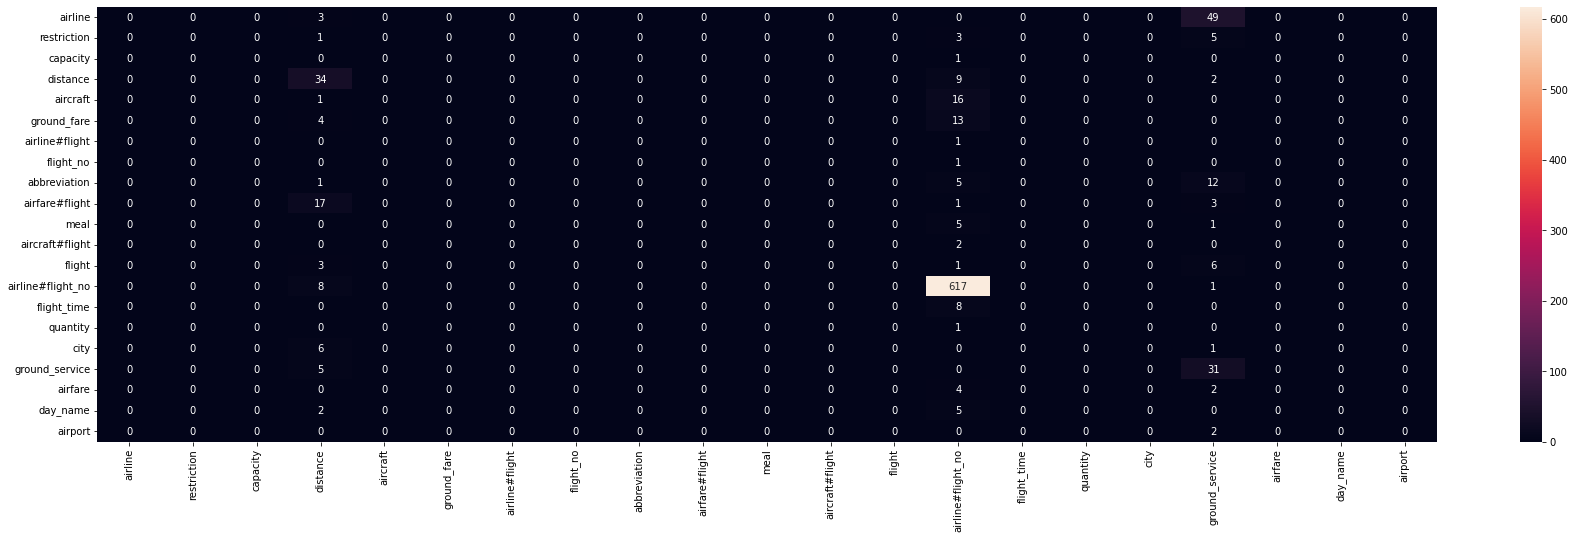

In [41]:
model = LSTM_model(False)
train_model(model=model, X_train=train_padded, y_train=y_train,
            X_val=dev_padded, y_val=y_dev,
            X_test=test_padded, y_test=y_test, 
            checkpoint=checkpoint, target=target, labels=labels)

###Word2Vec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 400)         92594400  
                                                                 
 lstm_5 (LSTM)               (None, 128)               270848    
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 28)                924       
                                                                 
Total params: 92,870,300
Trainable params: 92,870,300
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
18/18 [========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

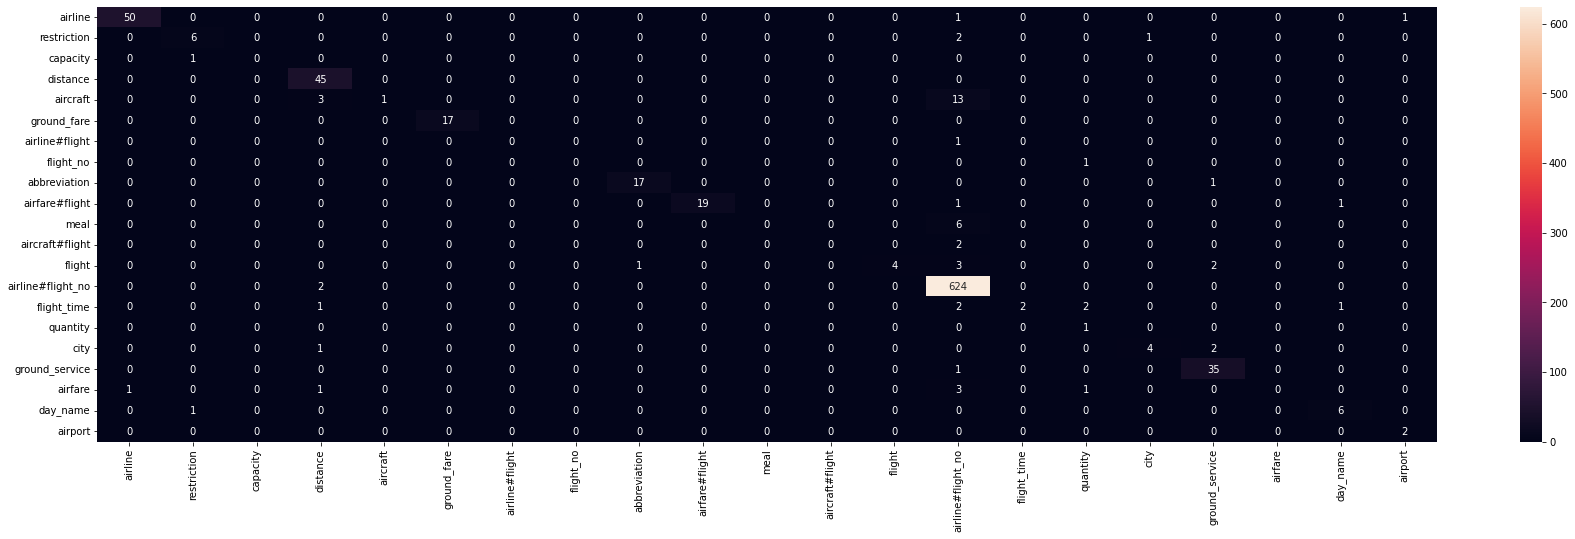

In [42]:
model = LSTM_model(True)
train_model(model=model, X_train=train_padded, y_train=y_train,
            X_val=dev_padded, y_val=y_dev,
            X_test=test_padded, y_test=y_test, 
            checkpoint=checkpoint, target=target, labels=labels)